In [1]:
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.model_selection import train_test_split

from text_models import TextClassifier, extract_text_blocks, tokenize_data, load_glove_embedding
from lstm_attention_model import AttentionLSTM, train_part, evaluate, predict_labels
from helper import Dataset, plot_graphs, progress_bar, consolidate_results
%load_ext autoreload
%autoreload 2

# Load Dataset 

The dataset is a pandas dataframe with two columns: Text labels and the text sentences and sub-sentences. There are 8 different categories(labels) in total. Each sentence could also have multiple categories(labels) associated with it.

In [2]:
df = pickle.load( open( "review_labelled.pkl", "rb" ))

In [3]:
df.sample(10)

,label,pp_sent
56288,[management],perks good name value of the top tier company
182615,[tech_product],cutting edge technology at least in some groups
62152,[management],or they 've been treated badly before
44113,[Job Security/Advancement],they invest into not only your work developmen...
14213,[business_vision_competitors],amazing business model
191441,[tech_product],interesting projects
22109,[Job Security/Advancement],with plenty of opportunity for over time
611033,[haras_discrim_sexism],up to num year paid leave for child birth rega...
5679,[culture_team],a lot of it is really good analysis work getti...
11063,[tech_product],interesting projects


Check for category imbalances in our dataset. Dataset looks well balanced in this case.

In [4]:
from collections import Counter
label_count = Counter([category for sublist in df.label.to_numpy() for category in sublist])
label_count

Counter({'Job Security/Advancement': 1151,
         'business_vision_competitors': 1042,
         'culture_team': 1148,
         'wlb_working_conditions': 1013,
         'salary_benefits': 1019,
         'management': 1064,
         'tech_product': 1009,
         'haras_discrim_sexism': 1001})

# Data Preparation

In [5]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Split data into batches of 64
train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=64)

Shape of data tensor: (8000,)
Found 3796 unique tokens.


In [6]:
# This variable holds the test results for all the models for later comparison.
model_results = []

# Train LSTM

Train a Multilabel text classifier using LSTM. This model has the following architecture: <br>
Input -> Word Embedding Layer -> LSTM -> Spatial Dropout -> Fully Connected -> RELU -> Fully Connected -> Sigmoid <br>
Here the LSTM output to the next fully connected layer is from the last time step only. All the model implementations could be found at text_models.py

In [7]:
model_lstm = TextClassifier(tokenizer, label_index)

history_lstm = model_lstm.train(X_train, y_train, 'LSTM', epochs = 10)
model_lstm.model.summary()

W0215 17:19:52.082726 4425194944 deprecation.py:506] From /Users/kshitijsharma/Documents/CS231n/assignment2/.env/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 12s 3ms/sample - loss: 0.4638 - binary_accuracy: 0.8315 - val_loss: 0.3881 - val_binary_accuracy: 0.8685
Epoch 2/10
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.3839 - binary_accuracy: 0.8680 - val_loss: 0.3709 - val_binary_accuracy: 0.8685
Epoch 3/10
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.3331 - binary_accuracy: 0.8720 - val_loss: 0.2856 - val_binary_accuracy: 0.8842
Epoch 4/10
3600/3600 [==============================] - 11s 3ms/sample - loss: 0.2555 - binary_accuracy: 0.8939 - val_loss: 0.2285 - val_binary_accuracy: 0.9038
Epoch 5/10
3600/3600 [==============================] - 10s 3ms/sample - loss: 0.2004 - binary_accuracy: 0.9215 - val_loss: 0.1892 - val_binary_accuracy: 0.9358
Epoch 6/10
3600/3600 [==============================] - 10s 3ms/sample - loss: 0.1504 - binary_accuracy: 0.9504 - val_loss: 0.1333 - val_binary_acc

Evaluate Model

In [8]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

1600/1600 [==============================] - 1s 589us/sample - loss: 0.0711 - binary_accuracy: 0.9780
Test Loss: 0.07110245324671269
Test Accuracy: 0.9779687523841858


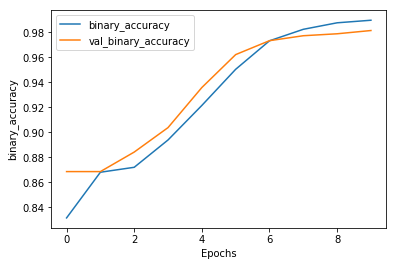

In [9]:
plot_graphs(history_lstm, 'binary_accuracy')

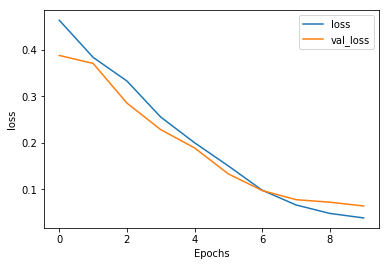

In [10]:
plot_graphs(history_lstm, 'loss')

In [11]:
h_lstm = consolidate_results(history_lstm, test_loss_lstm, test_acc_lstm, 'binary_accuracy', 'LSTM')
model_results.append(h_lstm)

# Train CNN

Model Architecture: <br> Input -> Word Embedding Layer -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid 

In [12]:
model_cnn = TextClassifier(tokenizer, label_index)

history_cnn = model_cnn.train(X_train, y_train, 'CNN', epochs = 10)
model_cnn.model.summary()

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 2s 420us/sample - loss: 0.4672 - binary_accuracy: 0.8560 - val_loss: 0.3743 - val_binary_accuracy: 0.8685
Epoch 2/10
3600/3600 [==============================] - 1s 345us/sample - loss: 0.3225 - binary_accuracy: 0.8766 - val_loss: 0.2340 - val_binary_accuracy: 0.8985
Epoch 3/10
3600/3600 [==============================] - 1s 368us/sample - loss: 0.1433 - binary_accuracy: 0.9474 - val_loss: 0.0845 - val_binary_accuracy: 0.9751
Epoch 4/10
3600/3600 [==============================] - 1s 406us/sample - loss: 0.0532 - binary_accuracy: 0.9848 - val_loss: 0.0510 - val_binary_accuracy: 0.9833
Epoch 5/10
3600/3600 [==============================] - 1s 376us/sample - loss: 0.0281 - binary_accuracy: 0.9926 - val_loss: 0.0405 - val_binary_accuracy: 0.9858
Epoch 6/10
3600/3600 [==============================] - 1s 373us/sample - loss: 0.0170 - binary_accuracy: 0.9957 - val_loss: 0.0353 - val_bina

Evaluate CNN Model

In [13]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_cnn))
print('Test Accuracy: {}'.format(test_acc_cnn))

1600/1600 [==============================] - 0s 67us/sample - loss: 0.0312 - binary_accuracy: 0.9897
Test Loss: 0.03119570579379797
Test Accuracy: 0.9896875023841858


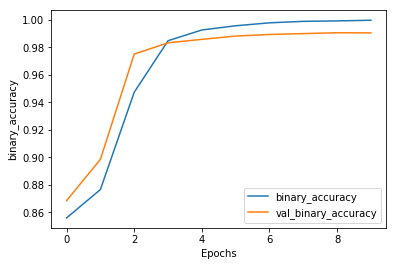

In [14]:
plot_graphs(history_cnn, 'binary_accuracy')

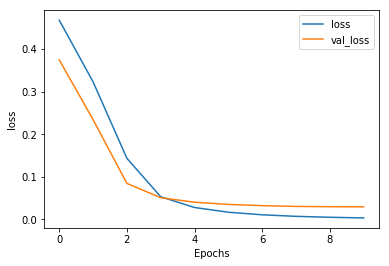

In [15]:
plot_graphs(history_cnn, 'loss')

In [16]:
h_cnn = consolidate_results(history_cnn, test_loss_cnn, test_acc_cnn, 'binary_accuracy', 'CNN')
model_results.append(h_cnn)

# Train CNN Glove

Model Architecture: 
Input -> GLoVe Word Embedding(Non trainable)  -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid

In [17]:
model_cnn_glove = TextClassifier(tokenizer, label_index)

history_cnn_glove = model_cnn_glove.train(X_train, y_train, 'CNN_Glove', epochs = 10)
model_cnn_glove.model.summary()

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 1s 317us/sample - loss: 0.3036 - binary_accuracy: 0.8892 - val_loss: 0.1799 - val_binary_accuracy: 0.9391
Epoch 2/10
3600/3600 [==============================] - 1s 275us/sample - loss: 0.1403 - binary_accuracy: 0.9547 - val_loss: 0.1174 - val_binary_accuracy: 0.9622
Epoch 3/10
3600/3600 [==============================] - 1s 285us/sample - loss: 0.0931 - binary_accuracy: 0.9708 - val_loss: 0.0906 - val_binary_accuracy: 0.9698
Epoch 4/10
3600/3600 [==============================] - 1s 278us/sample - loss: 0.0683 - binary_accuracy: 0.9803 - val_loss: 0.0752 - val_binary_accuracy: 0.9734
Epoch 5/10
3600/3600 [==============================] - 1s 273us/sample - loss: 0.0516 - binary_accuracy: 0.9862 - val_loss: 0.0666 - val_binary_accuracy: 0.9778
Epoch 6/10
3600/3600 [==============================] - 1s 300us/sample - loss: 0.0399 - binary_accuracy: 0.9901 - val_loss: 0.0600 - val_bina

Evaluate Glove Model

In [18]:
test_loss_glove, test_acc_glove = model_cnn_glove.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_glove))
print('Test Accuracy: {}'.format(test_acc_glove))

1600/1600 [==============================] - 0s 85us/sample - loss: 0.0561 - binary_accuracy: 0.9805
Test Loss: 0.05607964921742678
Test Accuracy: 0.9805468916893005


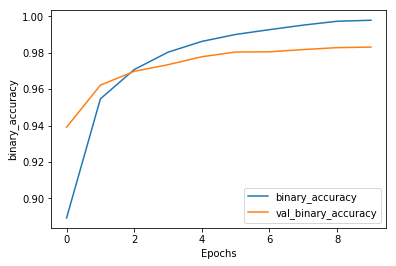

In [19]:
plot_graphs(history_cnn_glove, 'binary_accuracy')

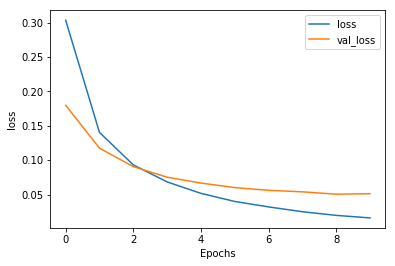

In [20]:
plot_graphs(history_cnn_glove, 'loss')

In [21]:
h_glove = consolidate_results(history_cnn_glove, test_loss_glove,
                           test_acc_glove, 'binary_accuracy', 'CNN GLoVe')
model_results.append(h_glove)

# Train MLP

Model Architecture: <br>
Input -> Word Embedding Layer -> 4x(Fully Connected -> RELU) -> Fully Connected -> Sigmoid <br>

In [22]:
model_mlp = TextClassifier(tokenizer, label_index)

history_mlp = model_mlp.train(X_train, y_train, 'MLP', epochs = 10)
model_mlp.model.summary()

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 1s 155us/sample - loss: 3.8826 - binary_accuracy: 0.7805 - val_loss: 1.1835 - val_binary_accuracy: 0.8609
Epoch 2/10
3600/3600 [==============================] - 0s 48us/sample - loss: 1.2320 - binary_accuracy: 0.8220 - val_loss: 0.9231 - val_binary_accuracy: 0.8660
Epoch 3/10
3600/3600 [==============================] - 0s 45us/sample - loss: 0.9521 - binary_accuracy: 0.8458 - val_loss: 0.8343 - val_binary_accuracy: 0.8672
Epoch 4/10
3600/3600 [==============================] - 0s 45us/sample - loss: 0.8187 - binary_accuracy: 0.8615 - val_loss: 0.7428 - val_binary_accuracy: 0.8685
Epoch 5/10
3600/3600 [==============================] - 0s 45us/sample - loss: 0.7230 - binary_accuracy: 0.8665 - val_loss: 0.6733 - val_binary_accuracy: 0.8685
Epoch 6/10
3600/3600 [==============================] - 0s 44us/sample - loss: 0.6667 - binary_accuracy: 0.8671 - val_loss: 0.6356 - val_binary_ac

Evaluate MLP Model

In [23]:
test_loss_mlp, test_acc_mlp = model_mlp.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_mlp))
print('Test Accuracy: {}'.format(test_acc_mlp))

1600/1600 [==============================] - 0s 28us/sample - loss: 0.5542 - binary_accuracy: 0.8683
Test Loss: 0.5541687643527985
Test Accuracy: 0.8682812452316284


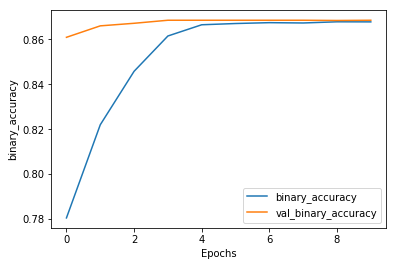

In [24]:
plot_graphs(history_mlp, 'binary_accuracy')

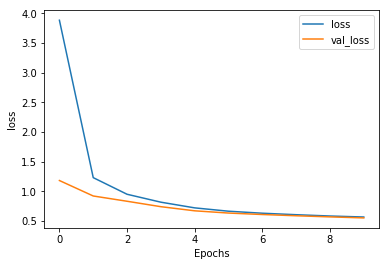

In [25]:
plot_graphs(history_mlp, 'loss')

In [26]:
h_mlp = consolidate_results(history_mlp, test_loss_mlp, test_acc_mlp, 'binary_accuracy', 'MLP')
model_results.append(h_mlp)

# LSTM with Attention

Model Architecture: 
Input -> Word Embedding Layer -> Bi-LSTM -> Attention layer -> Fully Connected -> Sigmoid 

In [27]:
sequence_length = 100
embedding_dim = 50
model_attention = AttentionLSTM(sequence_length, embedding_dim)

history_attention = train_part(model_attention, train_dset, val_dset, num_epochs=10, is_training=True)

Epoch 1, Loss: 0.4470224380493164, Accuracy: 85.75, Val Loss: 0.3909376263618469, Val Accuracy: 86.734375
Epoch 2, Loss: 0.40201056003570557, Accuracy: 86.81510925292969, Val Loss: 0.38866734504699707, Val Accuracy: 86.734375
Epoch 3, Loss: 0.38703280687332153, Accuracy: 86.828125, Val Loss: 0.3520542085170746, Val Accuracy: 86.7421875
Epoch 4, Loss: 0.28169071674346924, Accuracy: 89.51302337646484, Val Loss: 0.19319452345371246, Val Accuracy: 92.59375
Epoch 5, Loss: 0.1553483009338379, Accuracy: 94.9296875, Val Loss: 0.11727271974086761, Val Accuracy: 96.7109375
Epoch 6, Loss: 0.09540519118309021, Accuracy: 97.55989074707031, Val Loss: 0.08239178359508514, Val Accuracy: 97.5234375
Epoch 7, Loss: 0.06941118091344833, Accuracy: 98.47135925292969, Val Loss: 0.06266382336616516, Val Accuracy: 98.234375
Epoch 8, Loss: 0.051452167332172394, Accuracy: 98.96875, Val Loss: 0.05575566738843918, Val Accuracy: 98.328125
Epoch 9, Loss: 0.043038126081228256, Accuracy: 99.15625, Val Loss: 0.04867469

Evaluate model

In [28]:
test_loss_attention, test_acc_attention = evaluate(model_attention, test_dset)
print('Test Loss: {}'.format(test_loss_attention))
print('Test Accuracy: {}'.format(test_acc_attention))

Test Loss: 0.05338376387953758
Test Accuracy: 0.9842968583106995


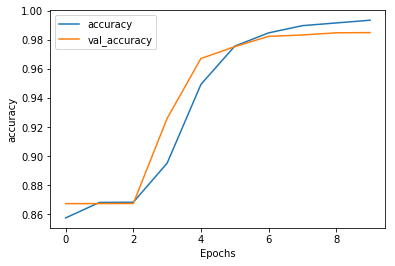

In [29]:
plot_graphs(history_attention, 'accuracy')

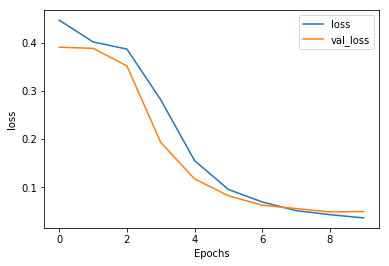

In [30]:
plot_graphs(history_attention, 'loss')

In [31]:
h_attention = consolidate_results(history_attention, test_loss_attention, test_acc_attention, 'accuracy', 'LSTM Attention')
model_results.append(h_attention)

# Comparison

Here before cross validation we can see LSTM, CNN, CNN Glove, LSTM Attention have very similar test accuracies. <br>
At this point we haven't done any cross validation so Val Accuracy and Test Accuracy have similar meaning.

In [32]:
col_names = ['Model', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Train Loss', 'Val Loss', 'Test Loss']
comparison_df = pd.DataFrame(data=model_results, columns=col_names)
comparison_df

,Model,Train Accuracy,Val Accuracy,Test Accuracy,Train Loss,Val Loss,Test Loss
0,LSTM,98.968750,98.145831,97.796875,0.038686,0.064345,0.071102
1,CNN,99.972224,99.052083,98.968750,0.003656,0.029736,0.031196
2,CNN GLoVe,99.788195,98.312497,98.054689,0.015931,0.051168,0.056080
3,MLP,86.781251,86.854166,86.828125,0.568995,0.553748,0.554169
4,LSTM Attention,99.341148,98.492187,98.429686,0.036274,0.049595,0.053384


The cross_validation function iterates over different hyper parameter settings to find the best model configuration. This could easily be extended for more detailed paramter tuning.

In [33]:
def cross_validation(model_type, X_train, y_train, tokenizer, label_index):

    learning_rates = np.linspace(1e-3, 5e-4, 5)
    regularization_strengths = np.linspace(0.001, 1.5, 1)

    best_val = -1.
    best_train = -1
    best_model = None
    best_lr = None
    best_reg = None
    progress_counter = 0
    total_tests = learning_rates.shape[0] * regularization_strengths.shape[0]

    print('Cross validation : ', model_type)
    
    start_time = time.time()
    
    for lr in learning_rates:
        for reg in regularization_strengths:
            # Train the network
            model = TextClassifier(tokenizer, label_index, verbose=0)
            history = model.train(X_train, y_train, model_type, epochs=10,learning_rate=lr, regularization=reg)
            val_acc_history = history['val_binary_accuracy']
            val_acc = val_acc_history[-1]

            if val_acc > best_val:
                del best_model
                best_val = val_acc
                best_model = model
                best_lr = lr
                best_reg = reg
            else:
                del model
                
            progress_counter += 1    
            progress_bar(progress_counter, total_tests)
            
    best_hist = best_model.history
    
    train_acc, val_loss, train_loss = best_hist['binary_accuracy'][-1], best_hist['val_loss'][-1], best_hist['loss'][-1]

    print("Execution time: %s seconds" % (time.time() - start_time))
    print('Best validation accuracy: %f - Train accuracy: %f - val loss: %f - train loss: %f'
          % (best_val, train_acc, val_loss, train_loss) )
    print('Best learning rate: %f - regularization : %f' % (best_lr, best_reg) )
    return best_model

In [34]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

best_lstm = cross_validation("LSTM", X_train, y_train, tokenizer, label_index)
best_mlp = cross_validation("MLP", X_train, y_train, tokenizer, label_index)
best_cnn = cross_validation("CNN", X_train, y_train, tokenizer, label_index)
best_glove = cross_validation("CNN_Glove", X_train, y_train, tokenizer, label_index)
best_attention = cross_validation("Attention", X_train, y_train, tokenizer, label_index)

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Cross validation :  LSTM
Status: [########################################] 5/5 
Execution time: 784.0467822551727 seconds
Best validation accuracy: 0.987266 - Train accuracy: 0.995365 - val loss: 0.039083 - train loss: 0.017893
Best learning rate: 0.000875 - regularization : 0.001000
Cross validation :  MLP
Status: [########################################] 5/5 
Execution time: 31.463531970977783 seconds
Best validation accuracy: 0.868203 - Train accuracy: 0.867865 - val loss: 0.423441 - train loss: 0.426895
Best learning rate: 0.001000 - regularization : 0.001000
Cross validation :  CNN
Status: [########################################] 5/5 
Execution time: 128.11821484565735 seconds
Best validation accuracy: 0.993906 - Train accuracy: 0.999896 - val loss: 0.021583 - train loss: 0.002028
Best learning rate: 0.001000 - regularization : 0.001000
Cross validation :  CNN_Glove
Status: [########################################] 5/5 


CNN seems to perform the best amongst all the other models here.
<br> 
CNN with GLoVe embedding is also slightly slower than CNN(with learnt embedding) while not performing any better.<br>
LSTM was approximately 7 times slower than CNN and also didn't perform any better than CNN. 
<br>
MLP was expected to perform the worst as by design it has no temporal information. 
<br><br>
Evaluating Test Accuracies on the best models after cross validation and hyper parameter tuning. 

In [36]:
test_loss, test_acc = best_cnn.evaluate(X_test,y_test)
print('CNN: Test Loss: {}'.format(test_loss))
print('CNN: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_glove.evaluate(X_test,y_test)
print('CNN Glove: Test Loss: {}'.format(test_loss))
print('CNN Glove: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_lstm.evaluate(X_test,y_test)
print('LSTM: Test Loss: {}'.format(test_loss))
print('LSTM: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_mlp.evaluate(X_test,y_test)
print('MLP: Test Loss: {}'.format(test_loss))
print('MLP: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = evaluate(best_attention.model, test_dset)
print('Attention: Test Loss: {}'.format(test_loss))
print('Attention: Test Accuracy: {}'.format(test_acc))

1600/1600 [==============================] - 0s 190us/sample - loss: 0.0262 - binary_accuracy: 0.9914
CNN: Test Loss: 0.02619475994259119
CNN: Test Accuracy: 0.991406261920929
1600/1600 [==============================] - 0s 227us/sample - loss: 0.0448 - binary_accuracy: 0.9845
CNN Glove: Test Loss: 0.044752007480710745
CNN Glove: Test Accuracy: 0.9844531416893005
1600/1600 [==============================] - 1s 926us/sample - loss: 0.0490 - binary_accuracy: 0.9852
LSTM: Test Loss: 0.048955942951142785
LSTM: Test Accuracy: 0.9852343797683716
1600/1600 [==============================] - 0s 30us/sample - loss: 0.4233 - binary_accuracy: 0.8683
MLP: Test Loss: 0.4232836264371872
MLP: Test Accuracy: 0.8682812452316284
Attention: Test Loss: 0.06706774979829788
Attention: Test Accuracy: 0.9792187213897705


The below code block loads a review, splits it into sentences and sub-sentences, and returns a flattened list

In [37]:
data_pros_cons = pickle.load( open( "review_pros_cons.pkl", "rb" ))
review = data_pros_cons.iloc[10,0]
blocks = extract_text_blocks(review)

Text example

In [38]:
print(review)

I worked for the internal marketing team (MarCom) on the creative side. The best thing about working at Apple is your coworkers. They do an excellent job of hiring incredibly intelligent, talented people. It's quite humbling to work alongside such accomplished people. You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you. Most of them are ego-free (about 70% of them) and will help you whenever possible. There are so many personality types, though nearly all of them are perfectionist Type A people. If that is your kind of crew, you'll do well.

The work usually comes in waves. When you're on, you're all the way on. For weeks at a time you can expect late nights and no weekends. On the flip side, when it's slow, it's very slow. You can often work from home or take comp days. During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.

In addition to this, the compensation is good. The stoc

In [39]:
# Helper function to print sentences and categories from the prediction list
def print_categories_sentences(prediction_dict):
    
    if len(prediction_dict) == 0:
        print ("No predictions made")
        
    for k,v in predictions.items():
        categories = [i[1] for i in v[0]]
        sentence = v[1]
        print(categories, sentence)

# Predict

The predict function takes in a list of important text blocks as input, and returns a list of "useful/important" sentences with their categories and confidence values. <br>
Below we visualize the outputs of the 4 models on the text above(review).

## CNN

In [42]:
predictions = best_cnn.predict(blocks)
print_categories_sentences(predictions)

['Job Security/Advancement'] I worked for the internal marketing team (MarCom) on the creative side.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['salary_benefits'] Most of them are ego-free (about 70% of them) and will help you whenever possible.
['wlb_working_conditions'] The work usually comes in waves.
['salary_benefits'] When you're on, you're all the way on.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['culture_team', 'wlb_working_conditions'] You can often work from home or take comp days.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is okay.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.
['culture_team'] Even in the relatively short time he's been in his role, he has made enormous leaps to give that company a real set of values that are current with this generation.


## CNN Glove

In [43]:
predictions = best_glove.predict(blocks)
print_categories_sentences(predictions)

['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['wlb_working_conditions'] The work usually comes in waves.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['wlb_working_conditions'] You can often work from home or take comp days.
['salary_benefits'] The stock program is okay.
['salary_benefits'] But the pay is more than fair and their annual reviews pretty much guarantee a raise, bonus, and/or more stock.
['culture_team'] Finally, Tim Cook seems like a genuinely good person.


## LSTM

In [44]:
predictions = best_lstm.predict(blocks)
print_categories_sentences(predictions)

['culture_team'] The best thing about working at Apple is your coworkers.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['Job Security/Advancement'] You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you.
['salary_benefits'] Most of them are ego-free (about 70% of them) and will help you whenever possible.
['Job Security/Advancement'] There are so many personality types, though nearly all of them are perfectionist Type A people.
['wlb_working_conditions'] The work usually comes in waves.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['wlb_working_conditions'] You can often work from home or take comp days.
['wlb_working_conditions'] During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is 

## MLP

In [45]:
predictions = best_mlp.predict(blocks)
print_categories_sentences(predictions)

No predictions made


## LSTM with Attention

In [47]:
predictions = predict_labels(blocks, best_attention.model, tokenizer, label_index)
print_categories_sentences(predictions)

['culture_team'] The best thing about working at Apple is your coworkers.
['culture_team'] They do an excellent job of hiring incredibly intelligent, talented people.
['Job Security/Advancement'] You'll always feel like the dumbest person in the room, which is great because everyone has so much to teach you.
['management'] There are so many personality types, though nearly all of them are perfectionist Type A people.
['haras_discrim_sexism'] If that is your kind of crew, you'll do well.
['wlb_working_conditions'] For weeks at a time you can expect late nights and no weekends.
['culture_team'] On the flip side, when it's slow, it's very slow.
['wlb_working_conditions'] You can often work from home or take comp days.
['wlb_working_conditions'] During downtimes it is not uncommon to go in for five hours including a long lunch and then go home.
['salary_benefits'] In addition to this, the compensation is good.
['salary_benefits'] The stock program is okay.
['salary_benefits'] But the pay i